## Superdense Coding Protocol

see [my website chapter 5](https://dev-undergrad.dev/qiskit/05_superdense_coding/) for what this is about.

In [1]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
# Setting bits we wish to transmit

c = "1"
d = "0"

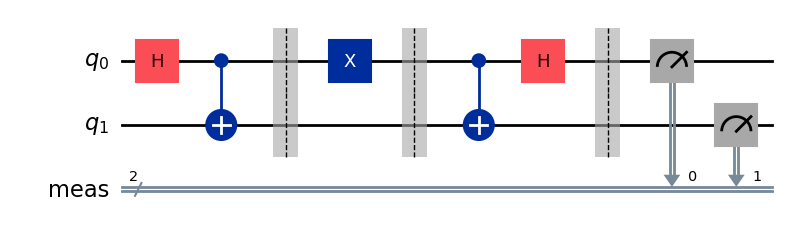

In [4]:
protocol = QuantumCircuit(2)

# Prepare ebit |ϕ+> used for superdense coding via Bell Circuit
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw('mpl'))

We use the `measure_all()` function, which measures all of the qubits and puts the results into a *single* classical register (containing 2 bits), as opposed to producing two *separate* bits. 

Let's run the `AerSimulator()` and see the result.

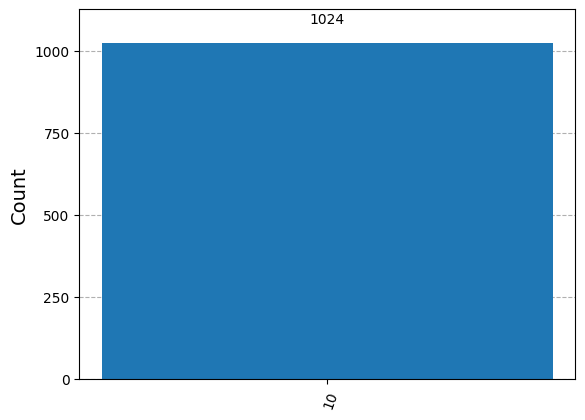

In [5]:
job = AerSimulator().run(protocol)
result = job.result()
statistics = result.get_counts()
plot_histogram(statistics)

As expected, $cd = 10.$ 

Let's now add an additional qubit as a random bit generator to randomly choose $c$ and $d$. 

To build the random bit generator, we first apply a Hadamard Gate: 

$$ |0\rangle \rightarrow |+\rangle = \frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle $$

which yields a superposition state with a 1/2 probability of measuring either $|0\rangle$ or $|1\rangle$. 

We then apply a meausurement gate on the superposed statevector and place the result into `c`.  

This process is repeated for `d`. 

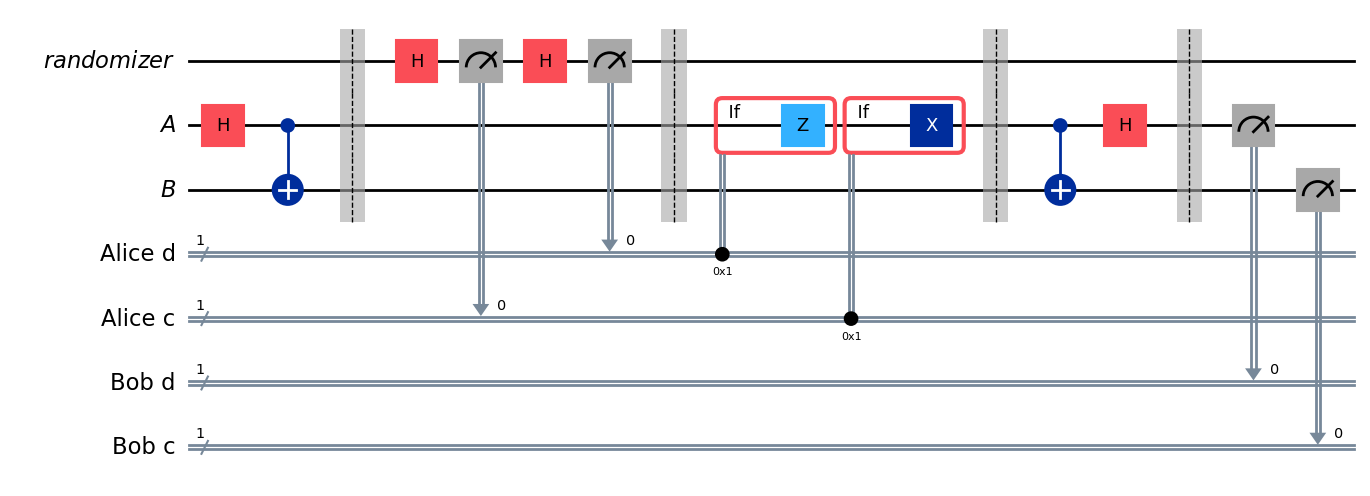

In [9]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits c and d.
test.h(rbg) # |0> -> |+>
test.measure(rbg, Alice_c) # Produces |0> or |1> with 1/2 probability
                           # Places result into `c`

test.h(rbg)                
test.measure(rbg, Alice_d) # Produces |0> or |1> with 1/2 probability
                           # Places result into `d`

test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw('mpl'))

Running the `AerSimulator()` again shows the results: Alice and Bob's classical bits always agree. 

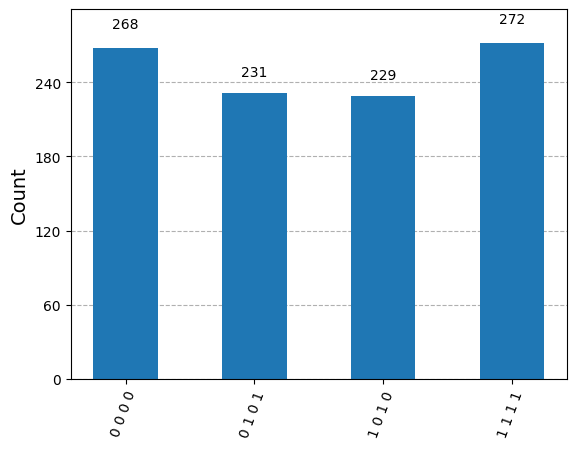

In [18]:
job = AerSimulator().run(test, shots = 1000)
result = job.result()
statistics = result.get_counts()

display(plot_histogram(statistics))